In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras_tuner import RandomSearch, HyperParameters

Preprocessing

In [2]:
import os
from PIL import Image, ImageEnhance
import numpy as np
import cv2

def preprocess_image(image_path, size=(224, 224)):
    try:
        img = Image.open(image_path)
        enhancer = ImageEnhance.Sharpness(img)
        img = enhancer.enhance(2.0)  # Increase sharpness

        image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        image = cv2.GaussianBlur(image, (5, 5), 0)
        img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        img = img.resize(size, Image.LANCZOS)
        img_array = np.array(img) / 255.0
        img = Image.fromarray((img_array * 255).astype(np.uint8))

        return img
    except Exception as e:
        print(f"Failed to process {image_path}: {str(e)}")
        return None

input_dir = 'images_train_test_val/train'
output_dir = 'processed_images'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):
        output_category_path = os.path.join(output_dir, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            preprocessed_img = preprocess_image(image_path)
            if preprocessed_img is not None:
                preprocessed_img.save(os.path.join(output_category_path, image_name))
            else:
                print(f"Skipping corrupted file: {image_path}")


In [3]:
# Directory paths
train_dir = 'processed_images'
val_dir = 'images_train_test_val/validation'
test_dir = 'images_train_test_val/test'

# Data Augmentation Setup
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,       # Mild shearing
    zoom_range=0.2,        # Mild zooming
    horizontal_flip=True,  # Useful for non-directional features
    # rotation_range=15,     # Slight rotation
    # width_shift_range=0.1, # Slight horizontal shifts
    # height_shift_range=0.1 # Slight vertical shifts
)

# Data Generators
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 10500 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


Base Model Creation

In [4]:
# def create_enhanced_model(optimizer='adam'):
#     model = Sequential()
#     # Initial Convolution and Pooling Layers
#     model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
#     model.add(BatchNormalization())  # Normalize activations of the previous layer
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     # Adding more Convolutional Layers
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     # Flatten and Dense Layers
#     model.add(Flatten())
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.5))  # Dropout to prevent overfitting
#     model.add(Dense(21, activation='softmax'))

#     model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#     return model

# model = create_enhanced_model()

# Model Builder with Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('conv1_kernel', values=[3, 5]),
                     activation='relu',
                     input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=hp.Int('conv2_filters', min_value=64, max_value=256, step=32),
                     kernel_size=hp.Choice('conv2_kernel', values=[3, 5]),
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=128, max_value=512, step=128),
                    activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.3, max_value=0.5, step=0.1)))
    model.add(Dense(21, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [5]:
# Hyperparameter Tuning
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=2,
    directory='tuner',
    project_name='LandUseClassification'
)

tuner.search(train_generator, epochs=5, validation_data=val_generator)

best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model with more epochs if needed
history = best_model.fit(train_generator, epochs=20, validation_data=val_generator)

2024-07-17 07:13:22.388217: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-07-17 07:13:22.388318: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-07-17 07:13:22.388321: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-07-17 07:13:22.389258: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-17 07:13:22.390011: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
64                |64                |conv1_filters
5                 |5                 |conv1_kernel
224               |224               |conv2_filters
3                 |3                 |conv2_kernel
128               |128               |dense_units
0.3               |0.3               |dropout
0.00027162        |0.00027162        |learning_rate

Epoch 1/5


2024-07-17 07:13:24.744987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


329/329 ━━━━━━━━━━━━━━━━━━━━ 1678s 5s/step - accuracy: 0.0494 - loss: nan - val_accuracy: 0.0476 - val_loss: nan
Epoch 2/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 1734s 5s/step - accuracy: 0.0474 - loss: nan - val_accuracy: 0.0476 - val_loss: nan
Epoch 3/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 1555s 5s/step - accuracy: 0.0499 - loss: nan - val_accuracy: 0.0476 - val_loss: nan
Epoch 4/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 1796s 5s/step - accuracy: 0.0493 - loss: nan - val_accuracy: 0.0476 - val_loss: nan
Epoch 5/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 1649s 5s/step - accuracy: 0.0445 - loss: nan - val_accuracy: 0.0476 - val_loss: nan
Epoch 1/5
  6/329 ━━━━━━━━━━━━━━━━━━━━ 1:09:05 13s/step - accuracy: 0.0334 - loss: 62.2325

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluation
test_generator.reset()
Y_pred = best_model.predict(test_generator, len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))
cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)

Model Creation

In [16]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Model Training
history = model.fit(
    train_generator,
    epochs=50,  # Increased epochs for detailed training curve
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.0601 - loss: 57.3874 - val_accuracy: 0.0476 - val_loss: 3.0446 - learning_rate: 0.0010
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - accuracy: 0.0576 - loss: 15.0002 - val_accuracy: 0.0476 - val_loss: 3.0446 - learning_rate: 0.0010
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.0551 - loss: 6.6515 - val_accuracy: 0.0490 - val_loss: 3.0410 - learning_rate: 0.0010
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.0536 - loss: 6.5093 - val_accuracy: 0.0519 - val_loss: 18.4976 - learning_rate: 0.0010
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.0526 - loss: 6.3471 - val_accuracy: 0.0486 - val_loss: 3.1783 - learning_rate: 0.0010
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.0531 - loss: 3.5136 - val_accuracy: 0.0476 - val_loss: 3.0564 - learning_rate: 0.0010
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.0524 - loss:

In [17]:
# Evaluate the model
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)
test_loss, test_acc = model.evaluate(test_generator)

print(f'Train accuracy: {train_acc:.4f}, Validation accuracy: {val_acc:.4f}, Test accuracy: {test_acc:.4f}')

165/165 ━━━━━━━━━━━━━━━━━━━━ 93s 565ms/step - accuracy: 0.0519 - loss: 8.5121
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 649ms/step - accuracy: 0.0553 - loss: 5.6600


/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 768ms/step - accuracy: 0.0386 - loss: 12.5288
Train accuracy: 0.0510, Validation accuracy: 0.0510, Test accuracy: 0.0495


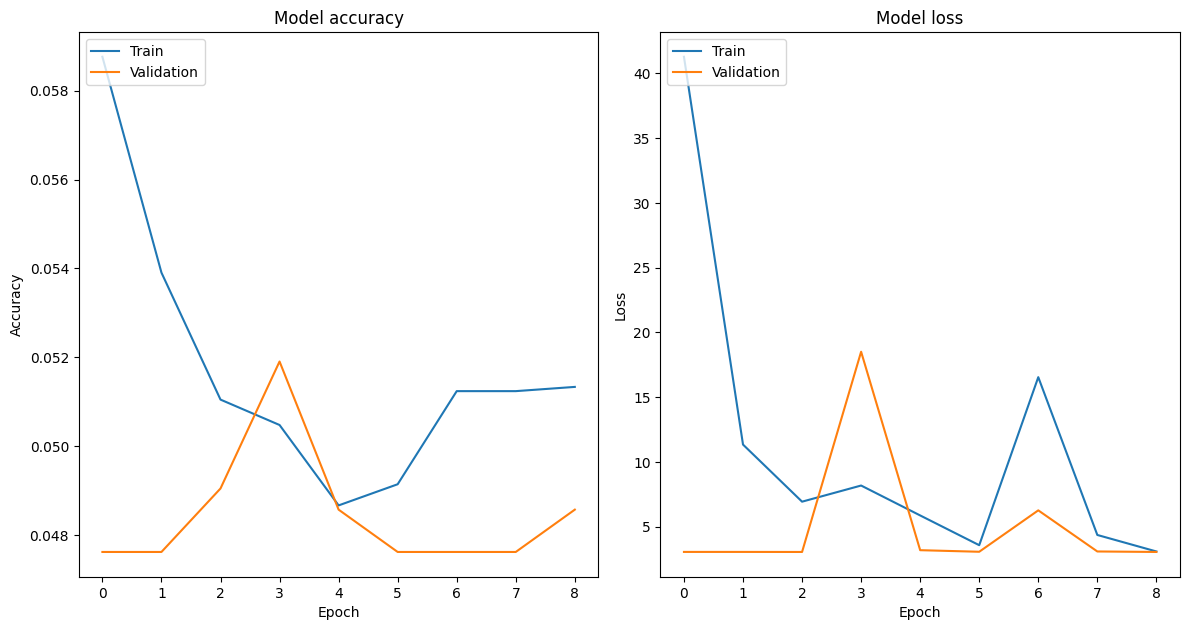

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()